In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py
from hdf5plotter import h5ls
from brownian import Cantilever, BrownianMotionFitter, get_data, u, Pf, calc_P_x0
from stanhelper import plot_all_traces, HDI_from_MCMC
import pystan

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
fh = h5py.File('brownianallpts155452.h5', 'r')

In [4]:
f = fh2['x'][:]
m = mask = (f > 61000) & (f < 63000)

(61950, 62050)

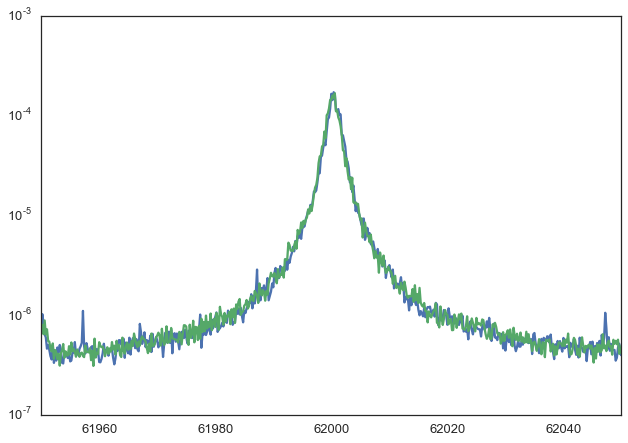

In [5]:
plt.semilogy(fh2['x'][:][m], fh2['y'][:][m])
plt.semilogy(fh['f_subset'][:], np.mean(fh['PSD_subset'][:], 0))
plt.xlim(61950, 62050)

In [17]:
all_standardized = np.ravel(fh['PSD_subset'][:] / np.mean(fh['PSD_subset'][:], 0))
m_peak = (fh['f_subset'][:] > 61995) & (fh['f_subset'][:] < 62005)
peak_standardized = (fh['PSD_subset'][:] / np.mean(fh['PSD_subset'][:], 0))[:, m_peak]
all_sorted = np.sort(all_standardized)
y = np.arange(all_sorted.size)/all_sorted.size

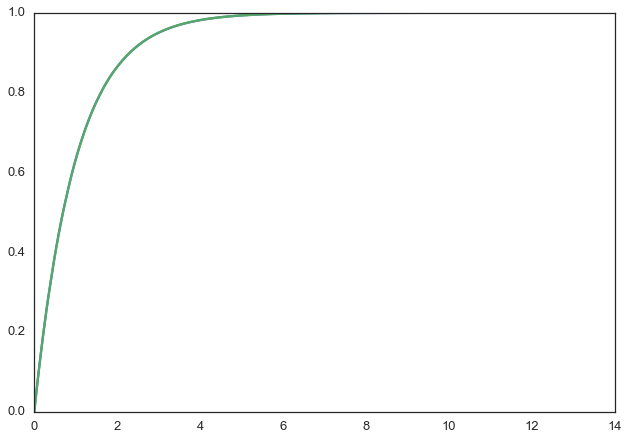

In [18]:
plt.plot(all_sorted, y)
plt.plot(all_sorted, 1-np.exp(-all_sorted))

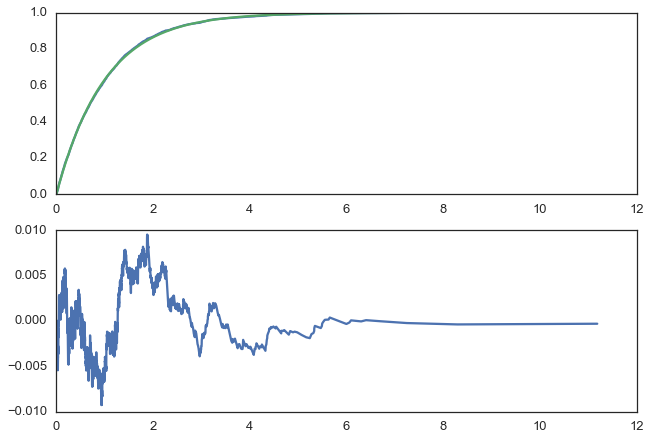

In [10]:
peak_sorted = np.sort(np.ravel(peak_standardized))
y_peak = np.arange(peak_sorted.size)/peak_sorted.size
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(peak_sorted, y_peak)
ax1.plot(peak_sorted, 1-np.exp(-peak_sorted))
ax2.plot(peak_sorted, y_peak - (1-np.exp(-peak_sorted)))


## Naive model

- Collect power spectral density of position fluctuation data, mean $y$, and standard deviation $y_\sigma$, for $N$ samples.

$$
\begin{align}
\mu_i &\sim P(x_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
\sigma_i & \sim \frac{y_\sigma}{\sqrt{N}} \\
y &\sim \mathcal{N}(\mu, \sigma)&
\end{align}
$$



In [11]:
bmf = BrownianMotionFitter(*get_data('brownianallpts155452.h5'), T=298,
                          est_cant=Cantilever(f_c=62*u.kHz,
                                     k_c=3.5*u.N/u.m,
                                     Q=28000*u.dimensionless)
                          )

In [12]:
bmf.calc_fit(61960, 62040)


Residuals
-------------------------------------
        Mean: -3.21e-02
   Std. dev.: 1.45e-01


(<matplotlib.figure.Figure at 0x11a8f5790>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d8d6990>)

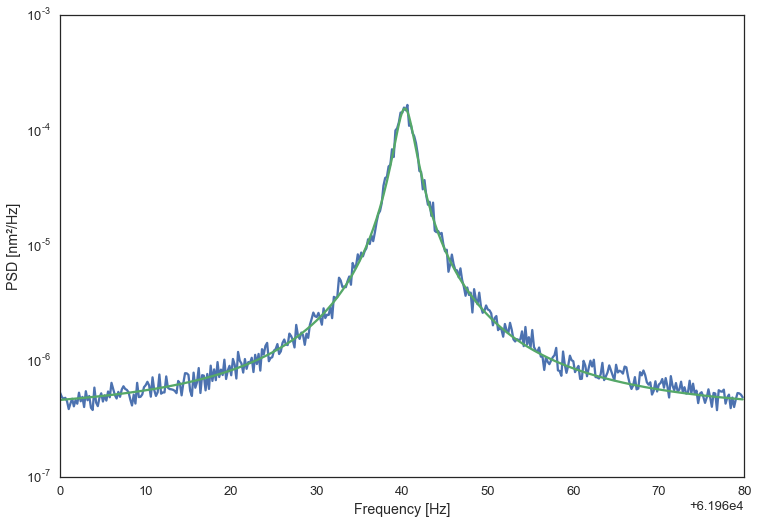

In [13]:
bmf.plot_fit()

(<matplotlib.figure.Figure at 0x11ab244d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a9b3c10>)

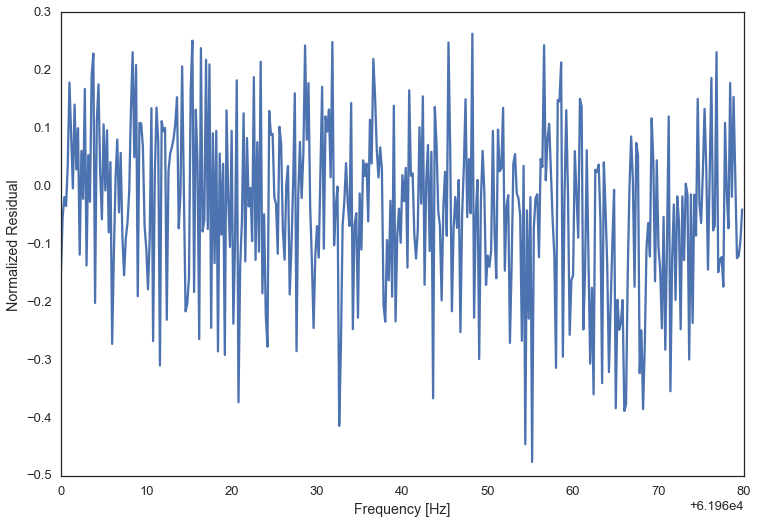

In [14]:
bmf.plot_reduced_residuals()

(<matplotlib.figure.Figure at 0x11a804510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a7d9b10>)

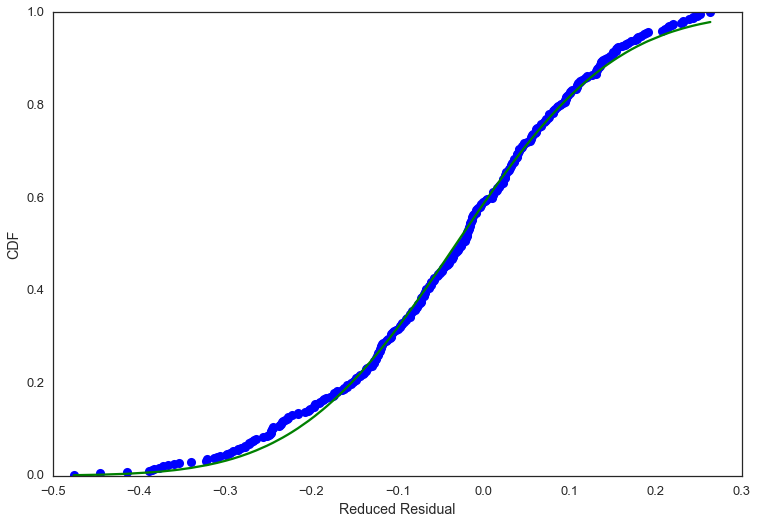

In [15]:
bmf.plot_cdf()

The model poorly describes the data, even with $N=64$ averages.

In [16]:
print(bmf.report())


    Input
    -----------------------------------------------
    Temperature           T: 298 kelvin

    Estimates
    -----------------------------------------------
    Spring constant     k_c: 3.5 newton/meter
    Resonance frequency f_c: 62 kilohertz
    Quality factor        Q: 28000 dimensionless
    
    Fitting
    -----------------------------------------------
    Fit frequency min f_min: 61960 hertz
    Fit frequency max f_max: 62040 hertz

    Results
    -----------------------------------------------
    Resonance frequency f_c: 62000.31(3) hertz
    Spring constant     k_c: 7.3(2) newton/meter
    Quality Factor        Q: 2.68(7)×10⁴ dimensionless
    Detector Noise         : 3.35(7)×10⁻⁷ nanometer²/hertz
            


# Baynesian fitting: same model

Let's use ``stan`` to examine the same naive model.

$$
\begin{align}
\mu_i &\sim P(x_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
\sigma_i & \sim \frac{y_\sigma}{\sqrt{N}} \\
y &\sim \mathcal{N}(\mu, \sigma)&
\end{align}
$$

In [274]:
def fh2data(fh, fmin, fmax, fc, kc, Q, Pdet=None, T=298,
            sigma_fc=5, sigma_kc=5, sigma_Q=10000, sigma_Pdet=1e-6,
            sigma_k=10):
    f_all = fh['x'][:]
    m = (f_all > fmin) & (f_all < fmax)
    f = f_all[m]
    psd_err = (fh['y_std'][:] / fh['y'].attrs['n_avg']**0.5)[m]
    psd = fh['y'][:][m]
    M, _ = fh['PSD_subset'][:].shape

    N = f.size
    
    # Scale data
    psd_scale = psd.mean()
    psd_scaled = psd / psd_scale
    
    if Pdet is None:
        mu_Pdet = np.percentile(psd_scaled, 25)
    else:
        mu_Pdet = Pdet / psd_scale
        
    
    return {'fmin': fmin,
     'fmax': fmax,
     'N': N,
     'M': M,       
     'y': psd_scaled,
     'y_err': psd_err / psd_scale,
     'f': f,
     'scale': psd_scale,
     'mu_fc': fc,
     'mu_kc': kc,
     'mu_Q': Q,
     'mu_Pdet': mu_Pdet,  # scaled
     'sigma_fc': sigma_fc,
     'sigma_kc': sigma_kc,
     'sigma_Q': sigma_Q,
     'sigma_Pdet': sigma_Pdet / psd_scale,
     'sigma_k': sigma_k,
     'T': T,
     }

def fh2data_all(fh, fmin, fmax, fc, kc, Q, Pdet=None, T=298,
            sigma_fc=5, sigma_kc=5, sigma_Q=10000, sigma_Pdet=1e-6,
            sigma_k=10):
    f_all = fh['f_subset'][:]
    m = (f_all > fmin) & (f_all < fmax)
    f = f_all[m]
    psd = fh['PSD_subset'][:][:, m]

    M, N = psd.shape
    
    # Scale data
    psd_scale = psd.mean()
    psd_scaled = psd / psd_scale
    
    
    
    
    if Pdet is None:
        mu_Pdet = np.percentile(psd_scaled, 25)
    else:
        mu_Pdet = Pdet / psd_scale
        
    
    return {'fmin': fmin,
     'fmax': fmax,
     'N': N,
     'y': psd_scaled,
     'f': f,
     'scale': psd_scale,
     'mu_fc': fc,
     'mu_kc': kc,
     'mu_Q': Q,
     'mu_Pdet': mu_Pdet,  # scaled
     'sigma_fc': sigma_fc,
     'sigma_kc': sigma_kc,
     'sigma_Q': sigma_Q,
     'sigma_Pdet': sigma_Pdet / psd_scale,
     'sigma_k': sigma_k,
     'T': T,
     'M': M
     }

In [30]:
mask2 = (fh['f_subset'][:] > 61960) & (fh['f_subset'][:] < 62040)

In [31]:
mask2

array([False, False, False, ..., False, False, False], dtype=bool)

In [32]:
psd_subset = fh['PSD_subset'][:][:, mask2]

In [33]:
psd_subset.shape

(64, 400)

In [34]:
d = fh2data(fh, 61960, 62040, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

In [35]:
def initial(d, k0=0.6, Pdet=None):
    if Pdet is None:
        Pdet = d['sigma_Pdet']*0.1
    return lambda: {'dfc': 0, 'kc': d['mu_fc'],
                    'Q': d['mu_Q'], 'Pdet': Pdet, 'k': k0}

In [36]:
naive_stan = """
data {
  int<lower=0> N;
  vector[N] f;
  vector[N] y;
  vector[N] y_err;
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real mu_Pdet;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
}
model {
    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    Pdet ~ normal(mu_Pdet, sigma_Pdet);
    

    
    y ~ normal( scale *
    ((2 * 1.381e-5 * T) / (pi() * Q * kc)) * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet,
            y_err);
}
"""

naive_stan2 = """
data {
  int<lower=0> N;
  vector[N] f;
  vector[N] y;
  vector[N] y_err;
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real mu_Pdet;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real sigma_k;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
  real<lower=0> k;
}
model {
    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    Pdet ~ normal(mu_Pdet, sigma_Pdet);
    k ~ normal(0, sigma_k);
    

    
    y ~ normal(
    ((2 * 1.381e-5 * T) / (pi() * Q * kc)) / scale * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet,
            k * y);
}
"""

naive_stan3 = """
data {
  int<lower=0> N;
  vector[N] f;
  vector[N] y;
  vector[N] y_err;
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real mu_Pdet;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
}
model {
    # Temporary data
    real prefactor;
    real fc2;
    fc2 <- (dfc + mu_fc)^2;
    prefactor <- ((2 * 1.381e-5 * T) / (pi() * Q * kc)) * (dfc + mu_fc)^3 / scale;

    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    Pdet ~ normal(mu_Pdet, sigma_Pdet);

    for (i in 1:N) {
        y[i] ~ normal(
                      prefactor / ( (f[i]^2 - fc2)^2 + f[i]^2 * fc2 / Q^2 ),
                      y_err[i]
                      );
    }
}
"""

naive_stan4 = """
data {
  int<lower=0> N;
  vector[N] f;
  vector[N] y;
  vector[N] y_err;
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real mu_Pdet;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real sigma_k;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
  real<lower=0> k;
}
model {
    # Temporary data
    real prefactor;
    real fc2;
    fc2 <- (dfc + mu_fc)^2;
    prefactor <- ((2 * 1.381e-5 * T) / (pi() * Q * kc)) * (dfc + mu_fc)^3 / scale;
    
    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    Pdet ~ normal(mu_Pdet, sigma_Pdet);
    k ~ normal(0, sigma_k);

    for (i in 1:N) {
        y[i] ~ normal(
                      prefactor / ( (f[i]^2 - fc2)^2 + f[i]^2 * fc2 / Q^2 ),
                      k * y[i]
                      );
    }
}
"""

In [37]:
m = pystan.StanModel(model_code=naive_stan)

In [38]:
m3 = pystan.StanModel(model_code=naive_stan3)

In [39]:
m2 = pystan.StanModel(model_code=naive_stan2)

In [40]:
m4 = pystan.StanModel(model_code=naive_stan4)

In [41]:
out4 = m4.sampling(data=d, init=initial(d, Pdet=0.02,), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

In [42]:
out4

Inference for Stan model: anon_model_9bf65b056b50b93101334429f1cf38d4.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.32  7.3e-4   0.07    0.2   0.28   0.32   0.37   0.45 8000.0    1.0
kc     7.32  5.9e-3   0.53   6.39   6.96   7.29   7.65   8.47 8000.0    1.0
Q     1.8e4   16.45 1471.3  1.5e4  1.7e4  1.8e4  1.9e4  2.1e4 8000.0    1.0
Pdet   0.02  1.8e-4   0.02 7.5e-4 8.8e-3   0.02   0.03   0.06 8000.0    1.0
k      0.35  1.4e-4   0.01   0.33   0.35   0.35   0.36   0.38 8000.0    1.0
lp__ 844.16    0.02   1.65 840.12  843.3 844.52 845.38 846.37 8000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 09:35:10 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [43]:
samp4 = out4.extract(permuted=True)

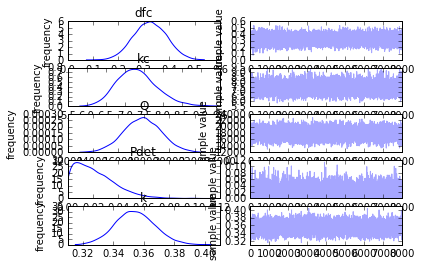

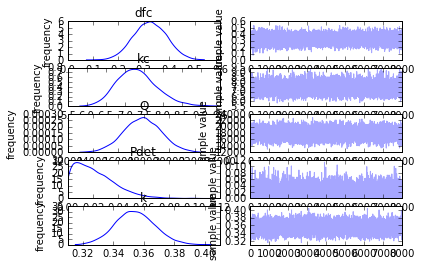

In [44]:
out4.traceplot()

In [45]:
out = m.sampling(data=d, init=initial(d, Pdet=0.02), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

In [46]:
out3 = m3.sampling(data=d, init=initial(d, Pdet=0.02), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

In [47]:
out3

Inference for Stan model: anon_model_6fe4dfcde23dc7830e237c53ebf9a265.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.34  3.2e-4   0.03   0.29   0.32   0.34   0.36    0.4 8000.0    1.0
kc      9.8  5.5e-3   0.49   8.93   9.46   9.77  10.11  10.85 8000.0    1.0
Q     1.3e4    8.39  750.6  1.1e4  1.2e4  1.3e4  1.3e4  1.4e4 8000.0    1.0
Pdet   0.02  1.8e-4   0.02 8.1e-4 8.4e-3   0.02   0.03   0.06 8000.0    1.0
lp__  -1690    0.02   1.53  -1694  -1690  -1689  -1689  -1688 8000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 09:37:27 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

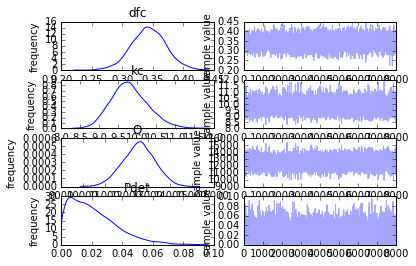

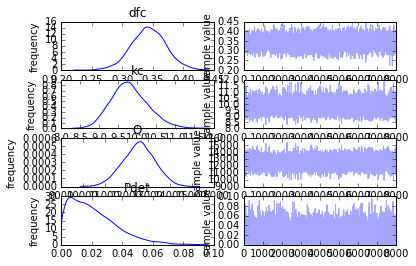

In [48]:
out3.traceplot()

In [49]:
samp3 = out3.extract(permuted=True)

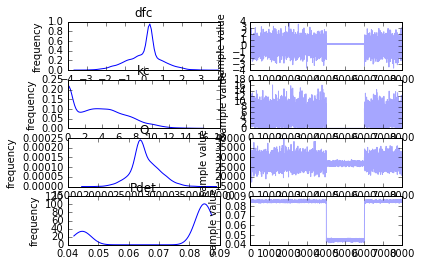

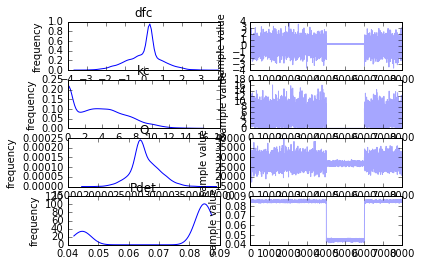

In [50]:
out.traceplot()

In [51]:
out2 = m2.sampling(data=d, init=initial(d, Pdet=0.02), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

In [52]:
out2

Inference for Stan model: anon_model_b01d96fd8d8d73705526c9987a94f2aa.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.2e-4   0.03   0.25   0.29   0.31   0.33   0.37 8000.0    1.0
kc     7.23  1.8e-3   0.16   6.93   7.12   7.23   7.34   7.55 8000.0    1.0
Q     2.7e4    7.69  688.0  2.6e4  2.7e4  2.7e4  2.7e4  2.8e4 8000.0    1.0
Pdet   0.04  1.1e-5 9.5e-4   0.04   0.04   0.04   0.05   0.05 8000.0    nan
k      0.14  5.6e-5 5.0e-3   0.13   0.14   0.14   0.14   0.15 8000.0    1.0
lp__ 1226.1    0.02   1.61 1222.0 1225.2 1226.4 1227.2 1228.2 8000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 09:38:15 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

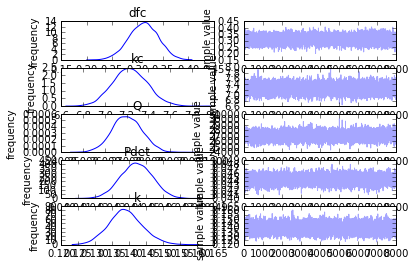

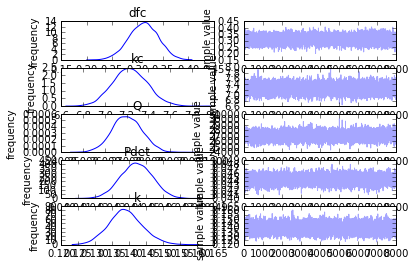

In [53]:
out2.plot()

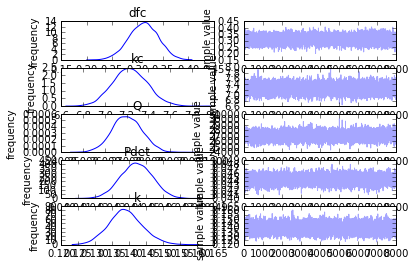

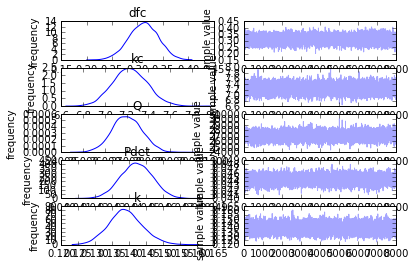

In [54]:
out2.traceplot()

In [55]:
samp2 = out2.extract(permuted=True)
samp = out3.extract(permuted=True)

In [56]:
samp

OrderedDict([(u'dfc',
              array([ 0.34464773,  0.3870403 ,  0.37023389, ...,  0.38251887,
                      0.32181602,  0.37642396])),
             (u'kc',
              array([  9.96886514,   9.27659218,  10.20208869, ...,   9.81413117,
                       9.38050969,   9.70577923])),
             (u'Q',
              array([ 12504.30868928,  13403.9946343 ,  11847.37789149, ...,
                      12439.51755106,  13135.02197991,  12756.75808565])),
             (u'Pdet',
              array([ 0.05683923,  0.02062687,  0.01428115, ...,  0.00428245,
                      0.01333465,  0.03829375])),
             (u'lp__',
              array([-1691.96408001, -1690.1835174 , -1689.45441606, ..., -1690.48569794,
                     -1688.91384973, -1689.23039181]))])

In [57]:
fc = d['mu_fc'] + np.median(samp2['dfc'])
Q = np.median(samp2['Q'])
kc = np.median(samp2['kc'])
psd50 = Pf(d['f'], calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude, fc, Q, np.mean(samp2['Pdet'])*d['scale'])

In [58]:
fc = d['mu_fc'] + np.median(samp['dfc'])
Q = np.median(samp['Q'])
kc = np.median(samp['kc'])
psd50_2 = Pf(d['f'], calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude, fc, Q, np.mean(samp['Pdet'])*d['scale'])

In [59]:
def Pfi(d, samp, i):
    fc = d['mu_fc'] + samp['dfc'][i]
    Q = samp['Q'][i]
    kc = samp['kc'][i]
    return Pf(d['f'], 
              calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude,
              fc, Q, samp['Pdet'][i]*d['scale']
             )

(3e-07, 0.0005)

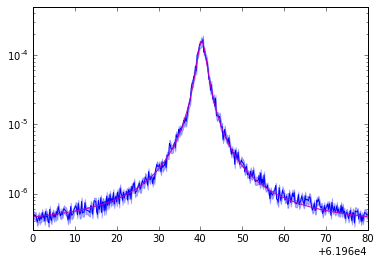

In [60]:
plt.semilogy(d['f'], d['y']*d['scale'])
plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
                 color='b', alpha=0.3)
# plt.semilogy(d['f'], psd50, 'g-')
plt.semilogy(d['f'], psd50, 'm-')
# plt.semilogy(d['f'], Pfi(d, samp, 2000))
plt.ylim(3e-7, 5e-4)

(1e-06, 0.0003)

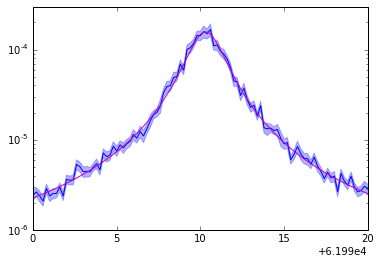

In [61]:
plt.semilogy(d['f'], d['y']*d['scale'])
plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
                 color='b', alpha=0.3)
# plt.semilogy(d['f'], psd50, 'g-')
plt.semilogy(d['f'], psd50, 'm-')
# plt.semilogy(d['f'], Pfi(d, samp, 2000))
plt.xlim(61990, 62010)
plt.ylim(1e-6, 3e-4)

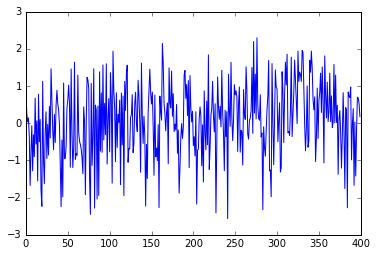

In [62]:
plt.plot( (d['y'] - (Pfi(d, samp2, 1000) / d['scale'])) / (samp2['k'][1000] * d['y']))

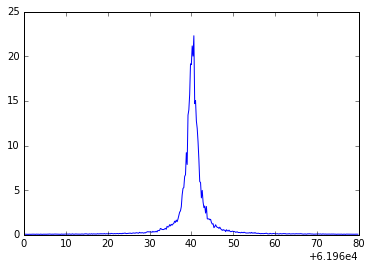

In [63]:
plt.plot(d['f'], d['y'])

In [64]:
Pfi(d, samp, 1000)

array([  2.31688600e-07,   2.33716299e-07,   2.35774363e-07,
         2.37863400e-07,   2.39984034e-07,   2.42136905e-07,
         2.44322668e-07,   2.46541996e-07,   2.48795579e-07,
         2.51084125e-07,   2.53408359e-07,   2.55769027e-07,
         2.58166892e-07,   2.60602740e-07,   2.63077376e-07,
         2.65591626e-07,   2.68146339e-07,   2.70742386e-07,
         2.73380664e-07,   2.76062092e-07,   2.78787614e-07,
         2.81558200e-07,   2.84374849e-07,   2.87238585e-07,
         2.90150462e-07,   2.93111564e-07,   2.96123004e-07,
         2.99185928e-07,   3.02301514e-07,   3.05470975e-07,
         3.08695557e-07,   3.11976545e-07,   3.15315258e-07,
         3.18713056e-07,   3.22171340e-07,   3.25691551e-07,
         3.29275173e-07,   3.32923737e-07,   3.36638817e-07,
         3.40422037e-07,   3.44275070e-07,   3.48199642e-07,
         3.52197530e-07,   3.56270569e-07,   3.60420651e-07,
         3.64649725e-07,   3.68959806e-07,   3.73352972e-07,
         3.77831366e-07,

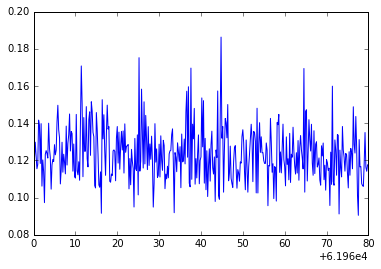

In [65]:
plt.plot(d['f'], d['y_err']/d['y'])

# Lognormal stan

Let's use our best guess, that each PSD is positive, with a mean $\mu$, given by $\mu(f) = P(f, f_\text{c}, k_\text{c}, Q)$. Then we have,

$$
\begin{align}
y_i & \sim \frac{1}{\mu_i}\exp(-\mu_i)& \\
\mu& \sim  P(f, f_\text{c}, k_\text{c}, Q)& \\
\end{align}
$$

Note: sigma is on a log scale; I can probably get away with just $\sigma ~ \alpha_\sigma$, with perhaps an exponentially weighted prior, with size 4.

In [128]:
exp_stan = """
data {
  int<lower=0> N;
  int<lower=0> M;
  vector[N] f;
  vector[N] y[M];
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real<lower=0> mu_Pdet;
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
}

model {
    vector[N] P;
    vector[N] beta;
    beta <- 1. ./ (((2 * 1.381e-5 * T) / (pi() * Q * kc)) / scale * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet);

    Pdet ~ exponential(inv(mu_Pdet));

    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    
    for (i in 1:M) {
        y[i] ~ exponential(beta);
    }
}
"""

In [129]:
mexp = pystan.StanModel(model_code=exp_stan)

In [229]:
dexp = fh2data_all(fh, 61954, 62046, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

In [230]:
mexp.sampling(data=dexp, init=initial(dexp), iter=3000, chains=3, warmup=1000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


Inference for Stan model: anon_model_b8936cf5b921b8fd3b58204ce05d8592.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.4e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.8e-3   0.14   6.76   6.94   7.03   7.13   7.31 6000.0    1.0
Q     2.7e4    7.97 617.72  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.0e-5 8.1e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.8e4    0.02    1.4  1.8e4  1.8e4  1.8e4  1.8e4  1.8e4 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 14:18:09 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [231]:
exp_out = _

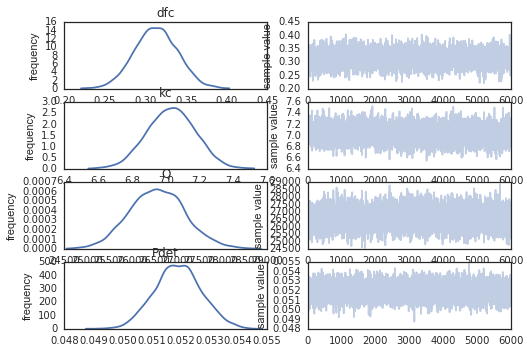

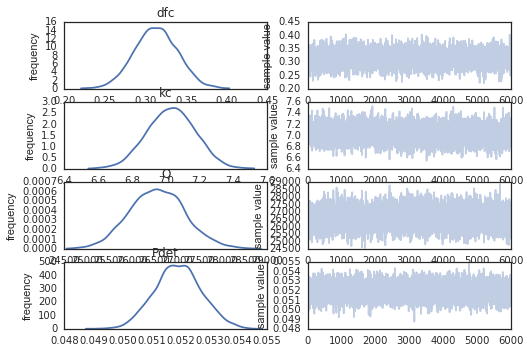

In [232]:
exp_out.traceplot()

In [233]:
exp_samp = exp_out.extract()

In [234]:
np.mean(exp_samp['Pdet'])*dexp['scale']

3.4140925819143727e-07

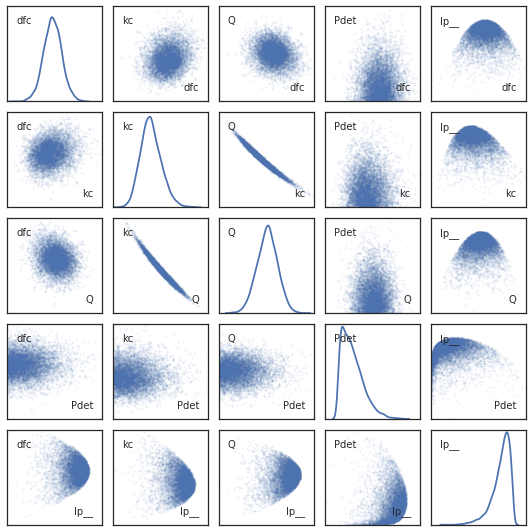

In [236]:
fig, ax = plot_all_traces(samp)

In [242]:
HDI_from_MCMC(exp_samp['kc'], 0.95)

(6.7628435825747468, 7.3120429959910487)

In [244]:
exp_out

Inference for Stan model: anon_model_b8936cf5b921b8fd3b58204ce05d8592.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.4e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.8e-3   0.14   6.76   6.94   7.03   7.13   7.31 6000.0    1.0
Q     2.7e4    7.97 617.72  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.0e-5 8.1e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.8e4    0.02    1.4  1.8e4  1.8e4  1.8e4  1.8e4  1.8e4 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 14:18:09 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [245]:
print("\n".join(bmf.report().split('\n')[-7:]))

    Results
    -----------------------------------------------
    Resonance frequency f_c: 62000.31(3) hertz
    Spring constant     k_c: 7.3(2) newton/meter
    Quality Factor        Q: 2.68(7)×10⁴ dimensionless
    Detector Noise         : 3.35(7)×10⁻⁷ nanometer²/hertz
            


In [246]:
bmf.k_c

<Quantity(7.29+/-0.23, 'newton / meter')>

In [247]:
np.mean(exp_samp['Q'])

26566.593070181749

In [248]:
np.percentile(exp_samp['Q'], 97.5)

27815.852078478027

In [249]:
np.percentile(exp_samp['Pdet'], 97.5)*dexp['scale']

3.5187446167225926e-07

In [250]:
np.percentile(exp_samp['Pdet'], 2.5)*dexp['scale']

3.3108567552875959e-07

In [253]:
np.mean(exp_samp['Pdet'])*dexp['scale']

3.4140925819143727e-07

(61950, 62050)

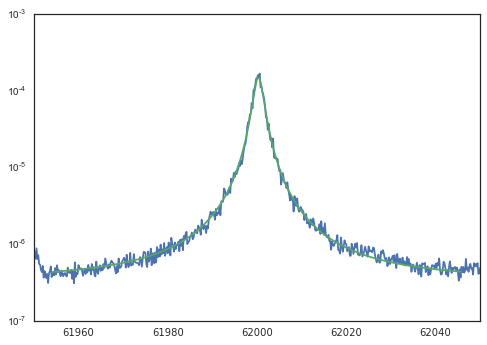

In [252]:
f = fh['f_subset'][:]
plt.semilogy(f, np.mean(fh['PSD_subset'][:], 0))
plt.semilogy(dexp['f'], Pfi(dexp, exp_samp, 2500))
plt.xlim(61950, 62050)

In [280]:
gamma_code = """
data {
  int<lower=0> N;
  int<lower=0> M;
  vector[N] f;
  vector[N] y;
  vector[N] y_err;
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real mu_Pdet;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
}
model {
    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    Pdet ~ exponential(mu_Pdet);
    

    
    y ~ gamma(M, M ./ (
    ((2 * 1.381e-5 * T) / (pi() * Q * kc)) / scale * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet)
            );
}
"""

In [281]:
gammod = pystan.StanModel(model_code=gamma_code)

In [282]:
d = fh2data(fh, 61954, 62046, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

In [284]:
# gammod.sampling(data=d, init=initial(dexp), chains=3, iter=100)
gammod.sampling(data=d, init=initial(dexp), chains=3, iter=3000, warmup=1000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


Inference for Stan model: anon_model_6b1131171a1e0ed7706776bbffa264fb.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.3e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.8e-3   0.14   6.76   6.93   7.03   7.13   7.31 6000.0    1.0
Q     2.7e4    8.03 621.87  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.1e-5 8.2e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.4e5    0.02   1.37  1.4e5  1.4e5  1.4e5  1.4e5  1.4e5 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 14:42:51 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [285]:
out_gam = _

In [286]:
out_gam

Inference for Stan model: anon_model_6b1131171a1e0ed7706776bbffa264fb.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.3e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.8e-3   0.14   6.76   6.93   7.03   7.13   7.31 6000.0    1.0
Q     2.7e4    8.03 621.87  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.1e-5 8.2e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.4e5    0.02   1.37  1.4e5  1.4e5  1.4e5  1.4e5  1.4e5 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 14:42:51 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [287]:
exp_out

Inference for Stan model: anon_model_b8936cf5b921b8fd3b58204ce05d8592.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.4e-4   0.03   0.26    0.3   0.31   0.33   0.36 6000.0    1.0
kc     7.03  1.8e-3   0.14   6.76   6.94   7.03   7.13   7.31 6000.0    1.0
Q     2.7e4    7.97 617.72  2.5e4  2.6e4  2.7e4  2.7e4  2.8e4 6000.0    1.0
Pdet   0.05  1.0e-5 8.1e-4   0.05   0.05   0.05   0.05   0.05 6000.0    nan
lp__  1.8e4    0.02    1.4  1.8e4  1.8e4  1.8e4  1.8e4  1.8e4 6000.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Feb 12 14:18:09 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).